In [1]:
!date

Sun Mar  1 18:50:50 PST 2020


In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")

In [4]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)
t2g["transcript_id"] = t2g["transcript_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_name"] + "_" + t2g["gene_id"]

In [5]:
assignments = gene.obs.subclass_label.values
unique = np.unique(assignments)
mat = gene.layers["log1p"].todense()
features = gene.var.gene_name.values

In [6]:
num_iso = t2g.groupby("gene_id")["transcript_id"].nunique()
num_iso[["Gm1992_ENSMUSG00000089699", "Gm37381_ENSMUSG00000102343"]]

gene_id
Gm1992_ENSMUSG00000089699     1
Gm37381_ENSMUSG00000102343    2
Name: transcript_id, dtype: int64

In [7]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [8]:
n = 998
dist = []
for uidx, u in enumerate(unique):
    mask = assignments == u
    
    mtx = mat[mask,:]
    
    arr = nd(mtx.sum(axis=0))
    
    top_genes_idx = arr.argsort()[-n:][::-1]
    
    x = num_iso[features[top_genes_idx]].values
    dist.append(x)

In [9]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

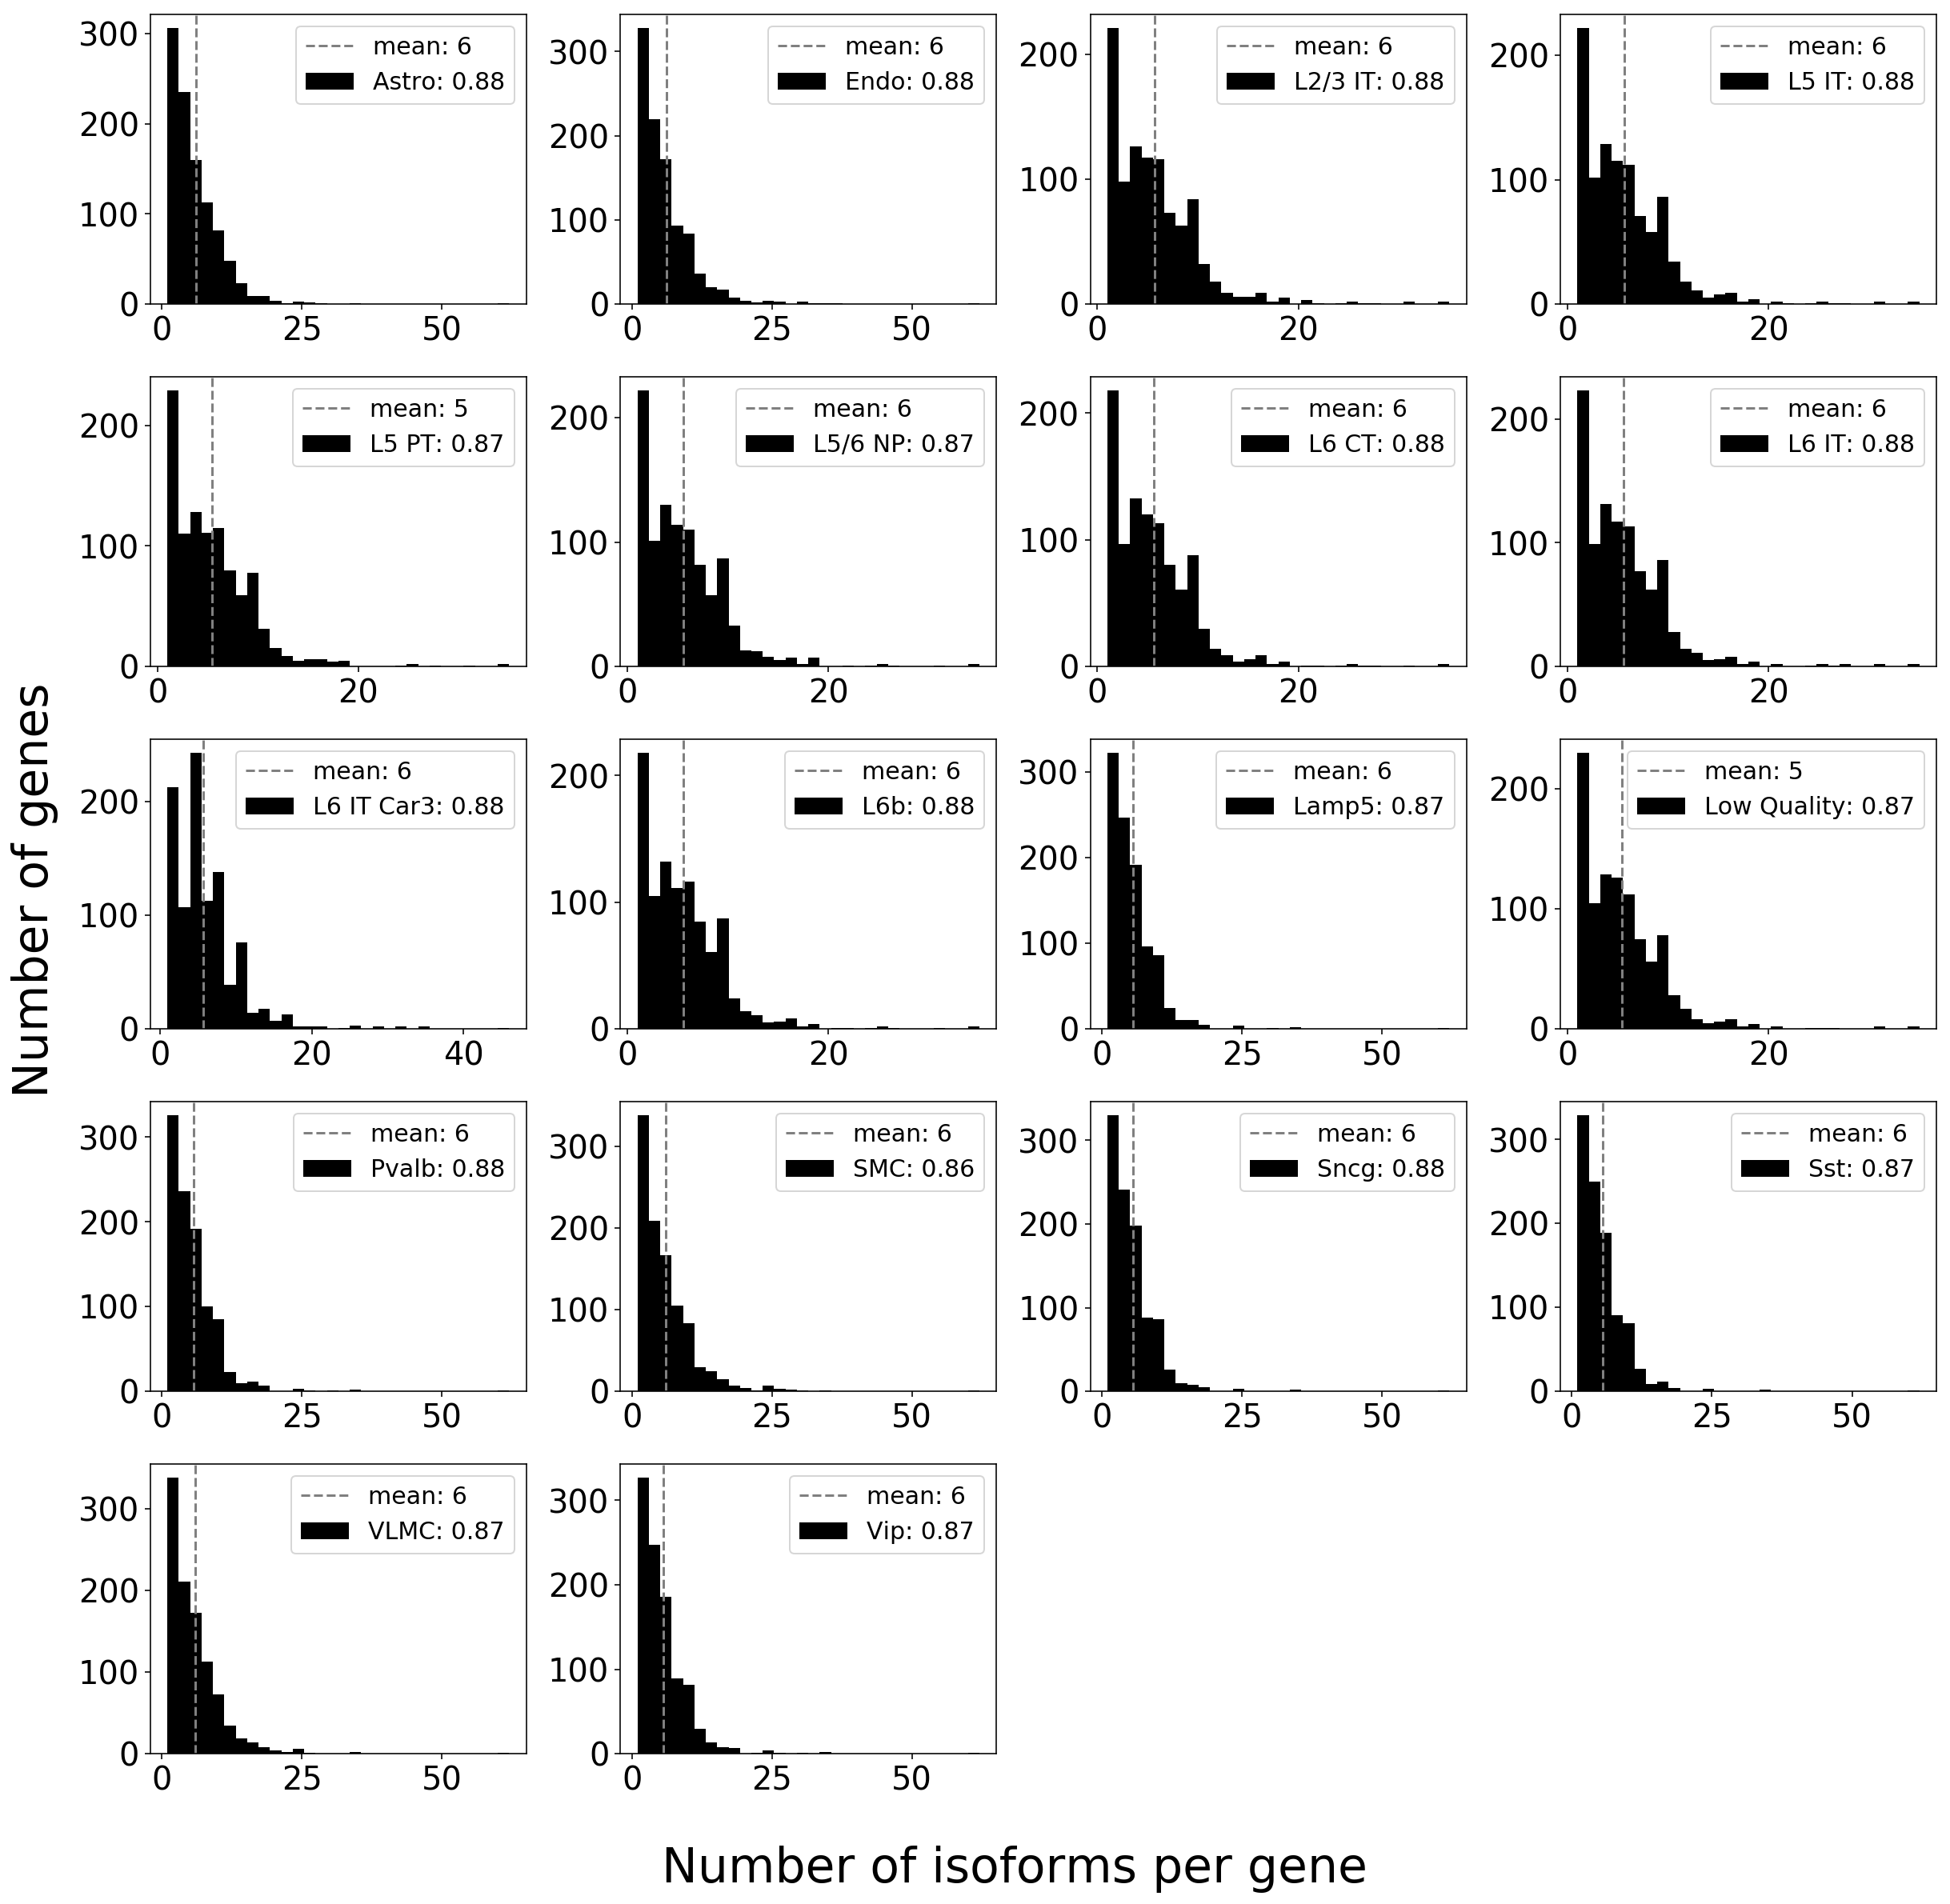

In [10]:
fig, ax = plt.subplots(figsize=(20,20), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
axs = trim_axs(ax, len(unique))
bins = 30
for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = dist[cidx]
    
    ax.hist(x, bins=bins,color="k", label="{}: {:,.2f}".format(c,(x>1).sum()/n))

    ax.axvline(x.mean(), color="grey", linestyle="--", label="mean: {:,.0f}".format(x.mean()))
    
    ax.legend(fontsize=15)
    #ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([])
    #ax.set_axis_off()
fig.text(0.5, 0.075, 'Number of isoforms per gene', ha='center', va='center', fontsize=30)
fig.text(0.075, 0.5, 'Number of genes', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./figures/isoform_per_gene.png", bbox_inches='tight',dpi=300)

plt.show()